# Example: Emotion Feature Extraction With Mexca

In this notebook, we will use the US presidential debate between Clinton and Trump in 2016 as an example to extract and compare emotion expressions with **mexca**. The video can be found on [YouTube](https://www.youtube.com/watch?v=DBhrSdjePkk), but we will use a file that is hosted by a third party. In contrast to the `demo.ipynb` notebook, we will dive deeper into different options and arguments that **mexca** provides and put more emphasis on analyzing the pipeline output.

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from huggingface_hub import notebook_login
from IPython.display import Video
from urllib.request import urlopen
from mexca.audio.extraction import VoiceExtractor
from mexca.audio.features import FeaturePitchF0
from mexca.audio.identification import SpeakerIdentifier
from mexca.audio.integration import AudioIntegrator
from mexca.core.pipeline import Pipeline
from mexca.text.transcription import AudioTextIntegrator, AudioTranscriber, TextRestaurator
from mexca.text.sentiment import SentimentExtractor
from mexca.video.extraction import FaceExtractor

If not already done, we first need to download the video file:

In [2]:
def download_example(url, filename):
    # Check if filename exists
    if not os.path.exists(filename):
        video = urlopen(url)

        with open(filename, 'wb') as file:
            file.write(video.read())

In [3]:
example_url = 'https://books.psychstat.org/rdata/data/debate.mp4'
filename = 'debate.mp4'

download_example(example_url, filename)

Video(filename)

## Building the Pipeline

Next, we build the pipeline by combining different steps for video, audio, and text processing. To extract features from faces shown in the video, we include a `FaceExtractor` object. We add `au_model='svm'` to use the pretrained Support Vector Machine classifier to extract facial action unit (AU) activations and `landmark_model='PFLD'` for the Practical Facial Landmark Detector (see [pyfeat](https://py-feat.org/pages/models.html) docs for details). From a quick inspection of the video, we can guess that mostly two faces will be shown (Clinton's and Trump's), so we set `min_clusters=2` and `max_clusters=2`. This means that detected faces will be assigned to two clusters based on their encoded representations (embeddings). In the current version of **mexca**, setting these thresholds is important as too many or too few face clusters might be chosen automatically otherwise.

In [4]:
n_clusters = 2

video = FaceExtractor(
    au_model='svm',
    landmark_model='PFLD',
    min_clusters=n_clusters,
    max_clusters=n_clusters
)

*Note*: mexca builds on pretrained models from the pyannote.audio package. Since release 2.1.1, downloading the pretrained models requires the user to accept two user agreements on Hugging Face hub and generate an authentication token. Therefore, to run the mexca pipeline, please accept the user agreements on [here](https://huggingface.co/pyannote/speaker-diarization) and [here](https://huggingface.co/pyannote/segmentation). Then, generate an authentication token [here](https://huggingface.co/settings/tokens). Use this token to login when running `notebook_login()`. You only need to login when running mexca for the first time.

In [ ]:
# Only required the first time to store the token
notebook_login()

For the audio processing, we combine a `SpeakerIdentifier` and `VoiceExtractor` in an `AudioIntegrator` object. The `SpeakerIdentifier` detects speech segmenets in the audio signal and assigns them to speaker clusters, whereas the `VoiceExtractor` calculates the voice pitch (fundamental frequency F0) which is an emotion expression. Because we have both higher and lower pitched voices in the signal, we choose a wide pitch range for the extraction.

In [5]:
audio = AudioIntegrator(
    SpeakerIdentifier(
        num_speakers=n_clusters
    ),
    VoiceExtractor(
        features={
            'pitchF0': FeaturePitchF0(
                pitch_floor=100.0,
                pitch_ceiling=500.0
            )
        }
    )
)

09/20/2022 15:51:13 - WARNING - speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
09/20/2022 15:51:13 - WARNING - speechbrain.utils.torch_audio_backend - The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


To extract the sentiment from the spoken text, we create a text processing component. It begins with transcribing the audio signal into text using the `AudioTranscriber` class. We must specify the language of the speech as the underlying model is language-specific. The resulting transcription is often noisy and does not contain any punctuation or grammatical structure. The `TextRestaurator` adds punctuation and a sentence structure to the transcription. Finally, the `SentimentExtractor` predicts a positive, negative, and neutral sentiment score for each sentence. We wrap the text components into an `AudioTextIntegrator` object to align the transcription to the audio signal.

In [6]:
text = AudioTextIntegrator(
    AudioTranscriber(language='english'),
    TextRestaurator(),
    SentimentExtractor()
)

09/20/2022 15:51:15 - INFO - huggingsound.speech_recognition.model - Loading model...


Now, we combine the video, audio, and text parts into a `Pipeline` instance, which will run them after each other and integrate the results.

In [7]:
pipeline = Pipeline(
    video=video,
    audio=audio,
    text=text
)

To run the **mexca** pipeline, we call the apply method, we call the `apply()` method. The video has a frame rate of 25 and to speed up the processing, we choose to only process every 5th frame by specifying `skip_frames=5`, assuming that emotion expressions don't change substantially faster than 200ms. For this example, we also indicate to only process the first 30 seconds using `process_subclip=(0, 30)`.

In [8]:
output = pipeline.apply(
    filename,
    skip_frames=5,
    process_subclip=(0, 30)
)

Analyzing video ...


100%|██████████| 750/750 [00:30<00:00, 24.43it/s]


Video done
Analyzing audio ...


100%|██████████| 4/4 [00:00<00:00, 1106.60it/s]


Audio done
Analyzing text ...


100%|██████████| 1/1 [00:28<00:00, 28.84s/it]


Text done


To simplify further processing, we convert the `features` attribute from the output of the pipeline into a data frame.

In [9]:
output_df = pd.DataFrame(output.features)

## Analyzing Facial Expressions

We start analyzing the output by comparing facial action unit activations between Clinton and Trump.

In [10]:
def stderr(x):
    """Calculate the standard error of the mean
    """
    return np.std(x)/np.sqrt(len(x))

In [11]:
# Expand action unit lists into separate columns
au_df = (output_df['face_aus']
    .apply(pd.Series)
    .rename(columns=lambda x: f'au_{x}')
)
au_df['face_id'] = output_df['face_id']

# Compute mean and standard error for each action unit
au_stats = au_df.groupby(['face_id']).agg([np.mean, stderr])

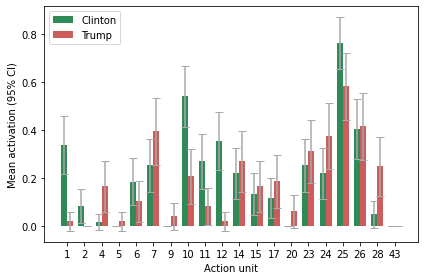

In [12]:
n_au = 20 # Nr of action units
aus = np.arange(n_au)

# Reference id of the action unit
au_ref = [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 20, 23, 24, 25, 26, 28, 43]

clinton_au_means = np.array([au_stats[f'au_{i}']['mean'][0] for i in aus])
clinton_au_stderrs = np.array([au_stats[f'au_{i}']['stderr'][0] for i in aus])

trump_au_means = np.array([au_stats[f'au_{i}']['mean'][1] for i in aus])
trump_au_stderrs = np.array([au_stats[f'au_{i}']['stderr'][1] for i in aus])

# Create bar plot with error bars
width = 0.35

fig, ax = plt.subplots()

ax.bar(aus-width/2, clinton_au_means, width, yerr=1.96*clinton_au_stderrs, capsize=4,
    ecolor='darkgray', label='Clinton', color='seagreen')
ax.bar(aus+width/2, trump_au_means, width, yerr=1.96*trump_au_stderrs, capsize=4,
    ecolor='darkgray', label='Trump', color='indianred')

ax.set_xlabel('Action unit')
ax.set_xticks(aus, au_ref)
ax.set_ylabel('Mean activation (95% CI)')
ax.legend()

fig.tight_layout()

plt.show()


The SVM model extracts the activations of 20 action units. The bar plot shows substantial differences between Clinton and Trump in the mean activations of units 1 (sadness, fear), 4 (fear, anger), 10, 11 (disgust, fear), 12 (happiness, contempt), and 28. This pattern could be interpreted as Clinton expressing more sad and fearful, but also happy emotions using her facial muscles than Trump. Trump in contrast might express more anger than Clinton.

## Analyzing the Voice

Besides facial emotion expressions, **mexca** also allows us to analyze vocal expressions. Currently, it only extracts the voice pitch measured as the fundamental frequency F0 from speakers in the video. Similar to the action units, we can compare voice pitch between Clinton and Trump.

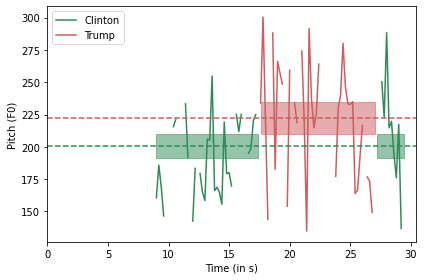

In [13]:
# Extract voice pitch and calculate statistics
clinton_pitch = output_df.pitchF0[output_df.speaker_id == 'SPEAKER_00']
clinton_time = output_df.time[output_df.speaker_id == 'SPEAKER_00']
trump_pitch = output_df.pitchF0[output_df.speaker_id == 'SPEAKER_01']
trump_time = output_df.time[output_df.speaker_id == 'SPEAKER_01']

clinton_pitch_mean = np.mean(clinton_pitch)
clinton_pitch_stderr = stderr(clinton_pitch)

trump_pitch_mean = np.mean(trump_pitch)
trump_pitch_stderr = stderr(trump_pitch)

# Create line plot with mean and confidence bands
fig, ax = plt.subplots()

ax.plot(clinton_time, clinton_pitch, label='Clinton', color='seagreen')
ax.plot(trump_time, trump_pitch, label='Trump', color='indianred')

ax.axhline(clinton_pitch_mean, ls='--', color='seagreen')
ax.fill_between(
    clinton_time[clinton_time < np.min(trump_time)],
    clinton_pitch_mean+1.96*clinton_pitch_stderr,
    clinton_pitch_mean-1.96*clinton_pitch_stderr,
    color='seagreen',
    alpha=0.5,
)
ax.fill_between(
    clinton_time[clinton_time > np.min(trump_time)],
    clinton_pitch_mean+1.96*clinton_pitch_stderr,
    clinton_pitch_mean-1.96*clinton_pitch_stderr,
    color='seagreen',
    alpha=0.5,
)
ax.axhline(trump_pitch_mean, ls='--', color='indianred')
ax.fill_between(
    trump_time,
    trump_pitch_mean+1.96*trump_pitch_stderr,
    trump_pitch_mean-1.96*trump_pitch_stderr,
    color='indianred',
    alpha=0.5,
)

ax.set_xlabel('Time (in s)')
ax.set_xticks(np.arange(35, step=5.0))
ax.set_ylabel('Pitch (F0)')
ax.legend()

fig.tight_layout()

plt.show()


The figure shows the voice pitch of Clinton and Trump over time and displays the mean pitch (dashed line) with confidence bands (95% CI). It shows that the baseline pitch of Trump's voice is higher on average than Clinton's. However, to draw meaningful conclusions about differences in expressed emotions, we would need to compare the pitch in specific parts of speech against the baseline (which goes beyond this example).

## Analyzing the Text

Next to facial expressions and voice features, **mexca** can also extract the sentiment from the spoken text. Again, we can compare the positive, negative, and neutral sentiment in the speech content between Clinton and Trump.

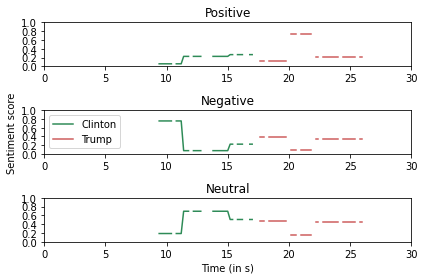

In [14]:
# Extract text sentiment
clinton_sent_pos = output_df.text_sent_pos[output_df.speaker_id == 'SPEAKER_00']
clinton_sent_neg = output_df.text_sent_neg[output_df.speaker_id == 'SPEAKER_00']
clinton_sent_neu = output_df.text_sent_neu[output_df.speaker_id == 'SPEAKER_00']
trump_sent_pos = output_df.text_sent_pos[output_df.speaker_id == 'SPEAKER_01']
trump_sent_neg = output_df.text_sent_neg[output_df.speaker_id == 'SPEAKER_01']
trump_sent_neu = output_df.text_sent_neu[output_df.speaker_id == 'SPEAKER_01']

# Create line plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(clinton_time, clinton_sent_pos, label='Clinton', color='seagreen')
ax1.plot(trump_time, trump_sent_pos, label='Trump', color='indianred')
ax2.plot(clinton_time, clinton_sent_neg, label='Clinton', color='seagreen')
ax2.plot(trump_time, trump_sent_neg, label='Trump', color='indianred')
ax3.plot(clinton_time, clinton_sent_neu, label='Clinton', color='seagreen')
ax3.plot(trump_time, trump_sent_neu, label='Trump', color='indianred')

ax1.set_title('Positive')
ax2.set_title('Negative')
ax3.set_title('Neutral')
ax3.set_xlabel('Time (in s)')
for ax in (ax1, ax2, ax3):
    ax.set_xticks(np.arange(35, step=5.0))
    ax.set_yticks(np.arange(1.2, step=0.2))
ax2.set_ylabel('Sentiment score')
ax2.legend()

fig.tight_layout()

plt.show()

We can see that Clinton starts her first turn with strongly negative sentiment ("I was against it") and becomes subsequently more neutral. Trump, in contrast, has a strongly positive peak in his turn when he talks about "the finest deal you've ever seen".

## Visualizing Face and Speaker Identification

In the last part of this example, we will create an annotated video to give a visual impression of how well mexca identifies faces and speakers. We use the `opencv` package to read, annotate, and save the video.

In [15]:
# Open video stream
cap = cv2.VideoCapture(filename)

# Get size for saving
width = int(cap.get(3))
height = int(cap.get(4))
   
size = (width, height)

# Open video writer
annotated = cv2.VideoWriter('debate_annotated.mp4', 
    cv2.VideoWriter_fourcc(*'MJPG'), 25, size)

# Init couners
i = 0
t = 0.0

while cap.isOpened():
    # Read frame
    ret, frame = cap.read()
    
    # Stop if no input received
    if not ret:
        break

    # Get matching outut from pipeline
    row = output_df[output_df.frame == i]
    
    # If matching output contains values update annotations
    if len(row) > 0:
        boxes = np.array(row.face_box)
        face_ids = np.array(row.face_id)
        speaker_id = np.array(row.speaker_id)[0]

    # Iterate over detected faces
    for j, box in enumerate(boxes):
        if isinstance(box, np.ndarray):
            (x1, y1, x2, y2) = box.astype('int')

            # Draw face box rectangle
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

            # Pos for face label
            x3 = int(x1+(x2-x1)/2)
            y3 = y1-5

            # Convert face ids to labels
            face_label = 'Clinton' if face_ids[j] == 0.0 else 'Trump'
            
            # Add face labels
            cv2.putText(frame, face_label, (x3, y3), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # Convert speaker ids to labels
    if speaker_id == 'SPEAKER_00':
        speaker_label = 'Clinton speaking ...'
    elif speaker_id == 'SPEAKER_01':
        speaker_label = 'Trump speaking ...'
    else:
        speaker_label = ''

    # Add speaker label
    cv2.putText(frame, speaker_label, (25, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)

    annotated.write(frame)

    cv2.imshow('frame', frame)

    # 'q' to stop or at 30s
    if cv2.waitKey(25) == ord('q') or t > 30.0:
        break

    i += 1
    t += 0.04

cap.release()
annotated.release()
cv2.destroyAllWindows()

In the annotated video, we can see that **mexca** identifies faces and speakers very well in this example. Keep in mind that we only process every 5th frame and therefore only update the annotations at this rate.

## Summary

In this example, we build a custom pipeline using the **mexca** package to extract emotion expressions from a video. We ran the pipeline on an excerpt from the US presidential debate 2016 between Clinton and Trump. We analyzed differences in action unit activations and voice pitch between the two candidate and visualized the face and speaker identification of the pipeline.